# Predicción de demanda de alquileres sitycleta por países

### En este trabajo final del curso de Inteligencia Artificial y Big data que estamos trabajandom, vamos a realizar la predicion de numero de usuarios de "sitycleta" de la empresa de Sagulpa.

En este trabajo lo que se pretende llevar a cabo es la creacíon y manipulación de datos optenidos por la empresa Sagulpa en su paguina web 

## Documentación

ID de cada Pais

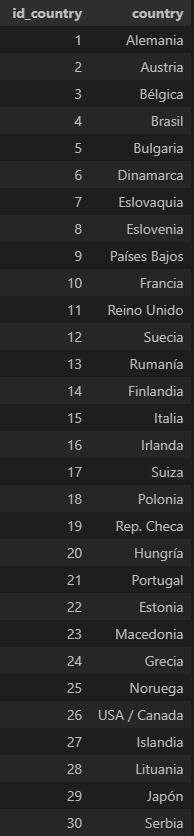

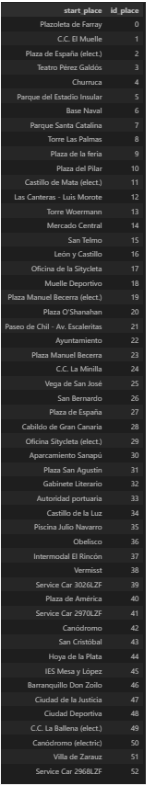

# Inicio del Proyecto

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pickle

Importamos los dataset con los que vamos a trabajar

In [ ]:
df_clima = pd.read_csv('data/time_df.csv', sep=';')
df_clima

In [ ]:
df_sagulpa = pd.read_csv('data/sagulpa_df.csv', sep=';')
df_sagulpa

Asiganamos las columnas climatologicas a la de sagulpa teniendo en cunta el día 

In [ ]:
# Renombrar las columnas en df_clima
nuevos_nombres = {' tmed': 'tmed', ' tmin': 'tmin', ' velmedia': 'velmedia'}
df_clima = df_clima.rename(columns=nuevos_nombres)

# Iterar sobre las filas de df_sagulpa
for index, row in df_sagulpa.iterrows():
    # Buscar una coincidencia en df_clima para el día actual
    match = df_clima[(df_clima['day'] == row['start_day'])]
    
    # Si se encontró una coincidencia
    if not match.empty:
        # Actualizar las columnas en df_sagulpa con los valores correspondientes de df_clima
        df_sagulpa.loc[index, 'prec'] = match.iloc[0]['prec']
        df_sagulpa.loc[index, 'presMax'] = match.iloc[0]['presMax']
        df_sagulpa.loc[index, 'presMin'] = match.iloc[0]['presMin']
        df_sagulpa.loc[index, 'tmax'] = match.iloc[0]['tmax']
        df_sagulpa.loc[index, 'tmed'] = match.iloc[0]['tmed']
        df_sagulpa.loc[index, 'tmin'] = match.iloc[0]['tmin']
        df_sagulpa.loc[index, 'velmedia'] = match.iloc[0]['velmedia']

Eliminamos columnas para preparar el DF_final

In [ ]:
colum_delete = ['start_month','start_min', 'start_h', 'start_seg', 'end_day', 'end_month', 'end_h', 'end_min', 'end_seg', 'user_time', 'country']
df_final = df_sagulpa.drop(columns=colum_delete)
df_final

En este caso hemos borrado las columnas que eran de tipo String y las fecha y hora en la que el usurio dejo la bicicleta ya que para nuestro proyecto no las vamos a usar

In [ ]:
# descargamos el df final de nuestro poryecto
df_final.to_csv('df_sagulpa.csv', index=False)

## Entrenamiento del modelo

### Primero vamos a separar los datos

In [ ]:
# Contar el número de cogidas de bicicletas por base y dia
word = df_final.groupby(['start_place','start_day']).size().reset_index(name='catch_for_day')

# hacemos una muestra buscando por el nombre de una base
word[word['start_place'] == 'C.C. El Muelle']

In [ ]:
# Realizar la fusión basada en la columna 'start_place' y 'start_day'
df_final = df_final.merge(word, on=['start_place', 'start_day'], how='left')

# Obtener los códigos numéricos y los valores únicos correspondientes
codes, unique_values = pd.factorize(df_final['start_place'])

# Agregar una nueva columna con los códigos numéricos
df_final['id_place'] = codes

In [ ]:
# Creamos un nuevo DataFrame con los valores únicos de 'start_place' e 'id_place'
unique_values = df_final[['start_place', 'id_place']].drop_duplicates()
unique_values

In [ ]:
# eliminamos la columna string de nombres de base
df_final = df_final.drop('start_place', axis=1)

# renombrar el nombre de las columnas
df_final.rename(columns={'start_day': 'day'}, inplace=True)

# Columnas que contienen valores enteros
columnas_enteros = ['id_country', 'day', 'catch_for_day', 'id_place']

# Convertir los valores enteros a valores de punto flotante
df_final[columnas_enteros] = df_final[columnas_enteros].astype(float)

# # mostramos el df
# df_final

In [ ]:
df_final

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
sns.heatmap(df_final.corr(), annot=True)

# Ajustar las etiquetas del eje x en horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

## Dividimos los datos para el Entrenamiento

In [ ]:
# Dividimos los datos de entrenamiento
X_Train  = df_final.drop(['catch_for_day'], axis=1)
Y_Train  = df_final['catch_for_day']

# train y test
x_train, x_test, y_train, y_test = train_test_split(X_Train, Y_Train, test_size=0.3, random_state=42)

### Segundo realizamos con el LazyPredict un estudio rapido sobre que modelos nos puede servir para el entrenamiento

In [ ]:
# Inicialización de LazyRegressor
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)

# Entrenamiento y evaluación de los modelos
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

# Imprimir los modelos
models

In [ ]:
l_estimators = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

cv = TimeSeriesSplit(n_splits = 10)
X_Train.reset_index(drop=True,inplace=True)

total_scores = []
for estimators in l_estimators:
    fold_accuracy = []
    regressor = RandomForestRegressor(n_estimators= estimators, criterion='absolute_error')
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(X_Train):
      
      # División train test aleatoria
      f_train = X_Train.loc[train_fold]
      f_test = X_Train.loc[test_fold]
      
      # entrenamiento y ejecución del modelo
      regressor.fit(x_train, y_train)
      Y_Pred = regressor.predict(x_test)
      
      # evaluación del modelo
      mae = mean_absolute_error(y_test,Y_Pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(l_estimators, total_scores, marker='o')
print ('Min Value :' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
    
plt.legend()
plt.show()

In [ ]:
best_est = l_estimators[np.argmin(total_scores)]
best_mae = min(total_scores)
print ("Min Value (estimators = %i, MAE = %6.2f)"  % (best_est, best_mae))

In [ ]:
# constructor
regressor =  RandomForestRegressor(n_estimators= best_est, criterion='absolute_error')

# fit and predict
for train_fold, test_fold in cv.split(X_Train):
  
  # División train test aleatoria
  f_train = X_Train.loc[train_fold]
  f_test = X_Train.loc[test_fold]
  
  # entrenamiento y ejecución del modelo
  regressor.fit(x_train,y_train)

Y_Pred = regressor.predict(x_test)

In [ ]:
Y_Pred

In [ ]:
mae = mean_absolute_error(y_test, Y_Pred)
print ("MAE = %6.2f"% (mae))

In [ ]:
# Grabamos el modelo en el directorio
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(regressor, file)

In [ ]:
# Cargamos el modelo
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

Realizamos una prueba con nuestro modelo entrenado para ver que resultados nos da

In [ ]:
x_in = np.asarray([23,13,0.0,1017.2,1015,25,22,19.4,1.1,7]).reshape(1,-1)
predicts = model.predict(x_in)
predicts[0]

In [ ]:
for i in range(1, 31):
    x_in = np.asarray([i, 24, 0.0, 1017.2, 1015, 25, 22, 19.4, 1.1, 7]).reshape(1, -1)
    predicts = model.predict(x_in)
    print(f"Predicción para i={i}: {predicts[0]}")

documentar
